# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import requests
import zipfile
import os
import random
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from PIL import Image

[2022-02-08 14:07:24.124 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:72 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [2]:
session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = boto3.session.Session().region_name
print("Default Region: {}".format(region))

try:
    role = sagemaker.get_execution_role()
except ValueError:
    role = os.environ["AWS_USER_ROLE"]
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-134915045317
Default Region: us-east-1
RoleArn: arn:aws:iam::134915045317:role/service-role/AmazonSageMaker-ExecutionRole-20220201T183740


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
def download_file(url, filename):
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, "wb") as file_context:
            file_context.write(r.content)

def unzip_file(filename, target_dir):
    if not os.path.isdir(target_dir):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(target_dir)

def isDataInS3(uri, session):
    return bool(sagemaker.s3.S3Downloader.list(uri, session))

def uploadDataToS3(data, uri, session):
    return sagemaker.s3.S3Uploader.upload(data, uri, sagemaker_session=session)

In [4]:
#TODO: Fetch and upload the data to AWS S3
file = "dogImages.zip"
directory = "./dogImages"
uri = f"s3://{bucket}/dogImages"
data_sets = ["train", "test", "valid"]
inputs={}
if not isDataInS3(uri, session):
    download_file("https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip", file)
    unzip_file(file, directory)
    for d in data_sets:        
        inputs[d] = uploadDataToS3(os.path.join(directory, d), sagemaker.s3.s3_path_join(uri, d), session)
        print(f"Done uploading '{d}'")
else:
    for d in data_sets:     
        inputs[d] = sagemaker.s3.s3_path_join(uri, d)
inputs

{'train': 's3://sagemaker-us-east-1-134915045317/dogImages/train',
 'test': 's3://sagemaker-us-east-1-134915045317/dogImages/test',
 'valid': 's3://sagemaker-us-east-1-134915045317/dogImages/valid'}

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 64, 256, 1024]),
    "epochs": IntegerParameter(5, 10)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge"
) # TODO: Your estimator here

tuner = HyperparameterTuner(
    base_tuning_job_name="hyperparameter-tuning-dog",
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
) # TODO: Your HP tuner here

In [7]:
# TODO: Fit your HP Tuner
tuner.fit(inputs) # TODO: Remember to include your data channels

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-02-08 09:36:06 Starting - Preparing the instances for training
2022-02-08 09:36:06 Downloading - Downloading input data
2022-02-08 09:36:06 Training - Training image download completed. Training in progress.
2022-02-08 09:36:06 Uploading - Uploading generated training model
2022-02-08 09:36:06 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '10',
 'lr': '0.0013278909424784707',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-02-08-08-56-50-309"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-134915045317/pytorch-training-2022-02-08-08-56-50-309/source/sourcedir.tar.gz"'}

In [9]:
best_hyperparameters = {
    "epochs": best_estimator.hyperparameters()["epochs"],
    "batch-size": best_estimator.hyperparameters()["batch-size"].replace('"', ""),
    "lr": best_estimator.hyperparameters()["lr"]
}
# best_hyperparameters = {"epochs": "10", "batch-size": "256", "lr": "0.0013278909424784707"} # in case of kernel reset
print(f"The best hyperparameters:\n  {best_hyperparameters}")

The best hyperparameters:
  {'epochs': '10', 'batch-size': '256', 'lr': '0.0013278909424784707'}


In [10]:
best_hyperparameters = {"epochs": "10", "batch-size": "256", "lr": "0.0013278909424784707"} # in case of kernel reset

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    # profiler
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    # debugger
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

In [12]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    base_job_name="smdebugger-dog",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    # debugger and profiler
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
) # TODO: Your estimator here

estimator.fit(inputs)

2022-02-08 14:08:10 Starting - Starting the training job...
2022-02-08 14:08:39 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-08 14:09:40 Starting - Preparing the instances for training.........
2022-02-08 14:11:10 Downloading - Downloading input data............
2022-02-08 14:13:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-08 14:13:03,589 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-08 14:13:03,615 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-08 14:13:03,619 sagemaker_pytorch_container.training INFO     Invoking user training script.
202

In [14]:
model_data_path = estimator.model_data
print("Model saved at " + model_data_path)
debugger_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print("Debugger artifacts saved at " + debugger_artifacts_path)

Model saved at s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/output/model.tar.gz
Debugger artifacts saved at s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/debug-output


In [15]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-08 14:34:00.856 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:72 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/debug-output


In [18]:
print(estimator.latest_training_job.name)
print(trial.tensor_names())

smdebugger-dog-2022-02-08-14-08-09-543
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.relu_input_2', 'layer3.2.relu_input_0', 'layer3.2.relu_input_1', 'layer3.2.relu_input_2', 'layer3.3.relu_input_0', 'layer3.3.relu_input_1', 'layer3.3.relu_input_2', 'layer3.4.relu_input_0', 'layer3.4.relu_input_

In [19]:
tensor_name = trial.tensor_names()[0]
print("Ternsor name: " + tensor_name)
print("Number of points for TRAIN: " + str(len(trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN))))
print("Number of points for EVAL: " + str(len(trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL))))

Ternsor name: CrossEntropyLoss_output_0
Number of points for TRAIN: 63
Number of points for EVAL: 35


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


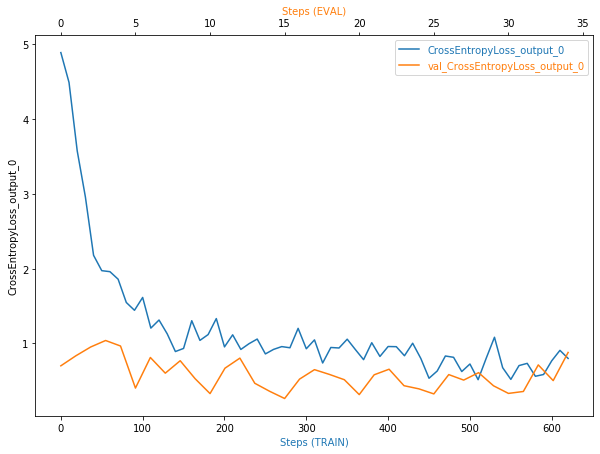

In [20]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, tensor_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
The lines are merging at the lower level. Thus, there is no anomalous behaviour.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?  
If the lines were not merging together, the model would be overfitted and needs less training. In contrast, if the lines were merging together but at a higher point, the model would be underfitted and needs more training.

In [21]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [22]:
! aws s3 ls {rule_output_path} --recursive

2022-02-08 14:25:12     392807 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-08 14:25:11     245489 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-08 14:25:06        549 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-08 14:25:06      38711 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-08 14:25:06        126 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-08 14:25:06        309 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-08 14:25:06       9578 smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottle

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-134915045317/smdebugger-dog-2022-02-08-14-08-09-543/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-134915045317/smdebugger

In [24]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [25]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [52]:
# TODO: Deploy your model to an endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(sagemaker.predictor.Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

pytorch_model = PyTorchModel(
    model_data=model_data_path, 
    role=role,
    entry_point='./inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor
)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

-----!

In [53]:
# TODO: Run an prediction on the endpoint
def extract_dog_breed(file):
    return os.path.basename(os.path.dirname(file)).rsplit('.')[1]

In [54]:
files = sagemaker.s3.S3Downloader.list(inputs["test"], session)
dog_breeds = [extract_dog_breed(item) for item in files]
dog_breeds = list(dict.fromkeys(dog_breeds))
print(dog_breeds)

['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie',

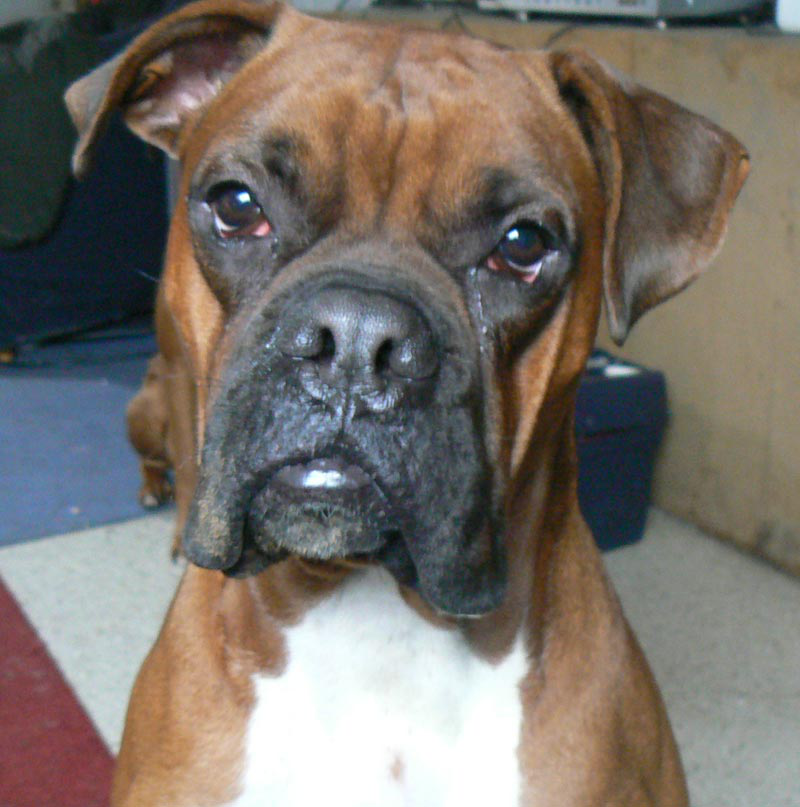

Expected dog breed: Boxer (s3://sagemaker-us-east-1-134915045317/dogImages/test/034.Boxer/Boxer_02381.jpg)
Predicted dog breed: Boxer


In [61]:
# TODO: Your code to load and preprocess image to send to endpoint for prediction
target_folder = "predictedImages/"

file_to_predict = random.choice(files)
sagemaker.s3.S3Downloader.download(file_to_predict, target_folder, sagemaker_session=session)
expected_breed = extract_dog_breed(file_to_predict)
with open(target_folder + os.path.basename(file_to_predict) , "rb") as f:
    image = f.read()
display(Image.open(io.BytesIO(image)))
response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})  # response is an array of 133 items, one for each breed
print(f"Expected dog breed: {expected_breed} ({file_to_predict})")
print(f'Predicted dog breed:' + dog_breeds[np.argmax(response, 1)[0]])

In [62]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()